# data gathered using `exp_definition.py`

i noticed massive performance differences in `hytm2` and `hytm2_3path` (say, for `insdel=20`) and started investigating.

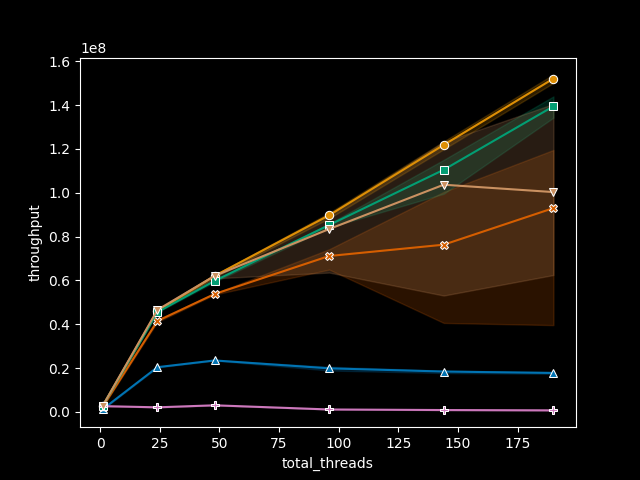

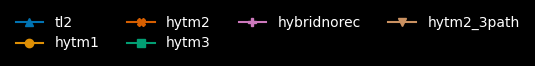

In [1]:
from IPython.display import Image
display(Image(filename='data/throughput-nrq0-JAX_CLUSTER-k100000-u20.png'))
display(Image(filename='data/legend.png'))

# compare steps `000982` and `000984`.

In [2]:
import sys ; sys.path.append('../../tools/data_framework') ; from run_experiment import *
from IPython.display import Markdown
def md(text):
    display(Markdown(text))
def show_data(fname):
    md('## `{}`'.format(fname))
    display(shell_to_list('cat {} | grep -A10000 "##### FINISHED PREFILL" | grep -E "PAPI_|time_cmd_output|throughput=|total fast htm commit|total fast htm abort|total show htm commit|total slow htm abort|total fallback commit|total fallback abort"'.format(fname), sep='\n'))

show_data('data/data000982.txt')
show_data('data/data000984.txt')

## `data/data000982.txt`

['total fast htm commit         : 7085165',
 'total fast htm abort          : 649091514',
 'total slow htm abort          : 1151084893',
 'total fallback commit         : 2480126',
 'total fallback abort          : 478495',
 'throughput=62461638',
 'PAPI_L2_TCM=35.1671',
 'PAPI_L3_TCM=5.44572',
 'PAPI_TOT_CYC=8242.43',
 'PAPI_TOT_INS=3975.04',
 '[time_cmd_output] time_elapsed_sec=10.46, faults_major=0, faults_minor=863065, mem_maxresident_kb=1708412, user_cputime=1898.31, sys_cputime=23.45, percent_cpu=18372%']

## `data/data000984.txt`

['total fast htm commit         : 1295134027',
 'total fast htm abort          : 650222881',
 'total slow htm abort          : 117059546',
 'total fallback commit         : 125431',
 'total fallback abort          : 15619',
 'throughput=145435161',
 'PAPI_L2_TCM=12.6363',
 'PAPI_L3_TCM=2.47279',
 'PAPI_TOT_CYC=3432.54',
 'PAPI_TOT_INS=1690.74',
 '[time_cmd_output] time_elapsed_sec=10.36, faults_major=0, faults_minor=92245, mem_maxresident_kb=361720, user_cputime=1904.23, sys_cputime=7.05, percent_cpu=18434%']

In [3]:
print(shell_to_str('grep "cmd_run" data/data000982.txt | cut -d"=" -f2-'))

In [4]:
display(Markdown('# Rerun until faults are high...'))
display(Markdown('cd ../dsbench ; LD_PRELOAD=../../lib/libjemalloc.so numactl --interleave=all perf record -g -e page-faults bin_JAX_CLUSTER/jax.dsbench_hytm2_3path -p -t 10000 -mr debra -mp none -ma new -k 100000 -i 20 -d 20 -rq 0 -rqsize 256 -nrq 0 -nwork 190'))

In [5]:
import sys ; sys.path.append('../../tools/data_framework') ; from run_experiment import *
display(Markdown('# Flame graph for page faults'))
shell_to_str('echo "<object data=\"out_pf.svg\"></object>" > out_pf.html')
show_html('out_pf.html', height=200)

In [6]:
md('# Flame graph for L2 misses')
shell_to_str('echo "<object data=\"out_l2.svg\"></object>" > out_l2.html')
show_html('out_l2.html', height=200)

In [22]:
import sys ; sys.path.append('../../tools/data_framework') ; from run_experiment import *
md('# Where are the L2 misses?')

md('prereq: generated perf_annotate_l2.txt via: `perf annotate -i ../dsbench/perf.data.l2 -n --stdio > perf_annotate_l2.txt`')

shell_to_str('cat perf_annotate_l2.txt | grep -E "[ ]*[0-9]+[ ]*:" | sort -nr | head -20 > perf_annotate_l2_hot.txt')
md('## Top 20 hotspots:')
show_txt('perf_annotate_l2_hot.txt', height=330)

shell_to_str('echo > perf_annotate_l2_hot_full.txt')
hotspots = shell_to_list('cat perf_annotate_l2_hot.txt', sep='\n')
for hs in hotspots:
    hs = ':'.join(hs.split(':')[:2])
    #print(hs)
    shell_to_str('(cat {} | grep -A3 -B12 "{}" ; echo ; echo ; echo ; echo ; echo) >> {}'.format('perf_annotate_l2.txt', hs, 'perf_annotate_l2_hot_full.txt'))

md('## Hotspot `details`:')
show_txt('perf_annotate_l2_hot_full.txt')

# Where are the L2 misses?

prereq: generated perf_annotate_l2.txt via: `perf annotate -i ../dsbench/perf.data.l2 -n --stdio > perf_annotate_l2.txt`

## Top 20 hotspots:

## Hotspot `details`:

In [23]:
import sys ; sys.path.append('../../tools/data_framework') ; from run_experiment import *
md('# Where are the page faults?')

md('prereq: generated perf_annotate_pf.txt via: `perf annotate -i ../dsbench/perf.data.pf -n --stdio > perf_annotate_pf.txt`')

shell_to_str('cat perf_annotate_pf.txt | grep -E "[ ]*[0-9]+[ ]*:" | sort -nr | head -20 > perf_annotate_pf_hot.txt')
md('## Top 20 hotspots:')
show_txt('perf_annotate_pf_hot.txt', height=330)

shell_to_str('echo > perf_annotate_pf_hot_full.txt')
hotspots = shell_to_list('cat perf_annotate_pf_hot.txt', sep='\n')
for hs in hotspots:
    hs = ':'.join(hs.split(':')[:2])
    #print(hs)
    shell_to_str('(cat {} | grep -A3 -B16 "{}" ; echo ; echo ; echo ; echo ; echo) >> {}'.format('perf_annotate_pf.txt', hs, 'perf_annotate_pf_hot_full.txt'))

md('## Hotspot `details`:')
show_txt('perf_annotate_pf_hot_full.txt')

# Where are the page faults?

prereq: generated perf_annotate_pf.txt via: `perf annotate -i ../dsbench/perf.data.pf -n --stdio > perf_annotate_pf.txt`

## Top 20 hotspots:

## Hotspot `details`:

seems like the massive L2 misses tend to be clustered about the hash table lookup: `while(data[ix])` in `hytm2_3path.cpp`

interestingly that's not where the page faults were. those were at allocations of `block` and `node`. (some avpair) ... seemingly stm path (htm slow path?)

i feel like collecting the SIZE of read/write sets (timeline?)... also timeline for transitions to different paths?